<a href="https://colab.research.google.com/github/arjunparmar/VIRTUON/blob/main/Prashant/Stage1/seg_bpix_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install tf-bodypix[all]

In [177]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2 as cv
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random

from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input
from tensorflow.keras.models import Sequential, Model

import matplotlib.pyplot as plt
%matplotlib inline

from tf_bodypix.api import download_model, load_model, BodyPixModelPaths

In [5]:
from model import build_model

In [6]:
bodyp = load_model(download_model(
    BodyPixModelPaths.MOBILENET_FLOAT_100_STRIDE_16
))

In [7]:
seg = build_model()

In [ ]:
#seg.summary()

In [9]:
seg.load_weights("model.11-0.8409.hdf5")

In [144]:
IMG_H, IMG_W = (384, 256)
img_h, img_w, img_c = (320,320,3)
n_classes = 20
common_interpolation = 'bilinear'

In [185]:
def bodypix_output(img):
    im = tf.image.resize(img, (1000, 1000), method = 'bicubic', preserve_aspect_ratio=True )
    result = bodyp.predict_single(im)
    mask = result.get_mask(threshold = 0.75)
    c_mask = result.get_colored_part_mask(mask)
    c_mask = tf.image.resize(c_mask, (IMG_H, IMG_W), method = 'bicubic', preserve_aspect_ratio=True ).numpy()
    c_mask = c_mask/255
    #c_mask = tf.math.argmax(c_mask, axis = -1)
    return c_mask

def segnet_output(img):
    output = cv.resize(img, dsize=(img_w, img_h))
    output = seg.predict(output.reshape( (1, img_h, img_w, img_c) )/255.0)
    output = output.reshape((img_h, img_w, n_classes))
    output = cv.resize(output, dsize=(IMG_W, IMG_H))
    #output = tf.math.argmax(output, axis = -1)
    return output

In [141]:
x_train = np.load('/content/drive/Shareddrives/Virtuon/Clothing Coparsing/dataset/x_train.npy').astype(np.float32)
x_test = np.load('/content/drive/Shareddrives/Virtuon/Clothing Coparsing/dataset/x_test.npy').astype(np.float32)

In [187]:
pos_train = np.zeros((len(x_train), IMG_H, IMG_W, 3), dtype=np.uint8)
pos_test = np.zeros((len(x_test), IMG_H, IMG_W, 3), dtype=np.uint8)
seg_train = np.zeros((len(x_train), IMG_H, IMG_W, 20), dtype=np.uint8)
seg_test = np.zeros((len(x_test), IMG_H, IMG_W, 20), dtype=np.uint8)

In [ ]:
for i in range(len(x_train)):
        pos_test[i] = bodypix_output(x_train[i])
pos_train

In [ ]:
for i in range(len(x_test)):
        pos_test[i] = bodypix_output(x_test[i])
pos_test

In [178]:
save_dir = "/content/drive/Shareddrives/Virtuon/Clothing Coparsing/dataset/" # path where you want to save

if not os.path.exists(save_dir): # if there is no exist, make the path
    os.makedirs(save_dir) 

np.save(save_dir+'pos_train.npy', pos_train)
np.save(save_dir+'pos_test.npy', pos_train)

In [ ]:
for i in range(len(x_train)):
        seg_train[i] = segnet_output(x_train[i])
seg_train

In [ ]:
for i in range(len(x_test)):
        seg_test[i] = segnet_output(x_test[i])
seg_test

In [190]:
save_dir = "/content/drive/Shareddrives/Virtuon/Clothing Coparsing/dataset/" # path where you want to save

if not os.path.exists(save_dir): # if there is no exist, make the path
    os.makedirs(save_dir) 

np.save(save_dir+'seg_train.npy', seg_train)
np.save(save_dir+'seg_test.npy', seg_test)

In [205]:
test_img = x_train[746]

In [206]:
test_img.shape

(384, 256, 3)

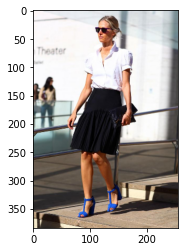

In [207]:
plt.imshow(cv.cvtColor(test_img, cv.COLOR_BGR2RGB)/255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


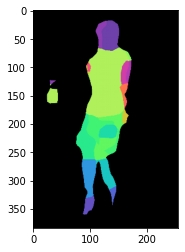

In [208]:
plt.imshow(bodypix_output(test_img))

In [209]:
bodypix_output(test_img).shape

(384, 256, 3)

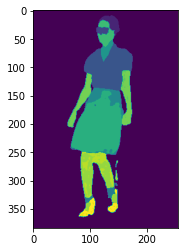

In [210]:
plt.imshow(tf.math.argmax(segnet_output(test_img), axis=-1))

In [211]:
segnet_output(test_img).shape

(384, 256, 20)